In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd
import os
import gpytorch
import argparse

from botorch.models import SingleTaskGP
from botorch.optim.fit import fit_gpytorch_torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import SpectralMixtureKernel, MaternKernel, RBFKernel, ScaleKernel


from voltron.means import EWMAMean, DEWMAMean, TEWMAMean

Warning no robinhood utils.


In [2]:
from GenerateDaysPredictions import GenerateStockPredictions

In [3]:
tckrs = ['TSLA', "F", "JPM", 'AAPL', "VIRT", "GS"]

In [4]:
import datetime

In [5]:
str(datetime.date.today())

'2021-12-13'

In [6]:
all_predicions_and_data = [GenerateStockPredictions(tckr, train_iters=250, end_date="2021-11-10") for tckr in tckrs]

Data Downloaded.
Producing TSLA Forecasts.....
Iter 1/250 - Loss: 17.944


/Users/wesleymaddox/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/wesleymaddox/Documents/GitHub/wjm_gpytorch/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Iter 51/250 - Loss: 0.862
Iter 101/250 - Loss: 0.779
Iter 151/250 - Loss: 0.772
Iter 201/250 - Loss: 0.771
Data Downloaded.
Producing F Forecasts.....
Iter 1/250 - Loss: 16.655
Iter 51/250 - Loss: 0.580
Iter 101/250 - Loss: 0.530
Iter 151/250 - Loss: 0.530
Iter 201/250 - Loss: 0.530
Data Downloaded.
Producing JPM Forecasts.....
Iter 1/250 - Loss: 16.592
Iter 51/250 - Loss: 0.136
Iter 101/250 - Loss: 0.040
Iter 151/250 - Loss: 0.026
Iter 201/250 - Loss: 0.024
Data Downloaded.
Producing AAPL Forecasts.....
Iter 1/250 - Loss: 15.912
Iter 51/250 - Loss: 0.144
Iter 101/250 - Loss: 0.063
Iter 151/250 - Loss: 0.054
Iter 201/250 - Loss: 0.053
Data Downloaded.
Producing VIRT Forecasts.....
Iter 1/250 - Loss: 16.387
Iter 51/250 - Loss: 0.317
Iter 101/250 - Loss: 0.259
Iter 151/250 - Loss: 0.257
Iter 201/250 - Loss: 0.257
Data Downloaded.
Producing GS Forecasts.....
Iter 1/250 - Loss: 16.267
Iter 51/250 - Loss: 0.159
Iter 101/250 - Loss: 0.099
Iter 151/250 - Loss: 0.095
Iter 201/250 - Loss: 0.095

In [7]:
all_predicions_and_data[0][0]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-10-06,423.790009,428.779907,406.049988,413.980011,413.980011,49146259
2020-10-07,419.869995,429.899994,413.845001,425.299988,425.299988,43127709
2020-10-08,438.440002,439.000000,425.299988,425.920013,425.920013,40421116
2020-10-09,430.130005,434.589905,426.460114,434.000000,434.000000,28925656
2020-10-12,442.000000,448.739990,438.579987,442.299988,442.299988,38791133
...,...,...,...,...,...,...
2021-11-03,1177.329956,1215.390015,1152.619995,1213.859985,1213.859985,34628519
2021-11-04,1234.410034,1243.489990,1217.000000,1229.910034,1229.910034,25397410
2021-11-05,1228.000000,1239.869995,1208.000000,1222.089966,1222.089966,21628812


In [8]:
all_predictions = torch.stack([x[1] for x in all_predicions_and_data])

In [9]:
all_predictions.shape

torch.Size([6, 1000, 20])

In [10]:
all_predictions = all_predictions.permute(1, 2, 0).exp()

In [11]:
all_predictions.shape

torch.Size([1000, 20, 6])

In [12]:
final_day_idx = torch.tensor([x[0].Close.values[-1] for x in all_predicions_and_data])

In [13]:
all_predictions.shape

torch.Size([1000, 20, 6])

In [14]:
market_predictions = all_predictions.mean(-1)

In [15]:
stacked_prev_day = torch.cat((final_day_idx.mean() * torch.ones(all_predictions.shape[0], 1), 
                              market_predictions[..., :-1]), dim=-1)
market_returns = (market_predictions - stacked_prev_day) / stacked_prev_day

In [16]:
market_returns.shape

torch.Size([1000, 20])

In [17]:
avg_market_returns = market_returns.mean(0)

In [18]:
stacked_prev_day_all = torch.cat((final_day_idx * torch.ones(1000, 1, 5), all_predictions[..., :-1, :]), dim=-2)

RuntimeError: The size of tensor a (6) must match the size of tensor b (5) at non-singleton dimension 2

In [ ]:
stock_returns = (all_predictions - stacked_prev_day_all) / stacked_prev_day_all

In [ ]:
excess_returns = (stock_returns - 1e-4) * 252 # 1e-4 is approximately daily returns on a 3%

In [ ]:
stock_returns.shape

In [ ]:
avg_market_returns.shape

In [ ]:
plt.subplots(figsize = (12, 5))
plt.plot(avg_market_returns, label = "Market Based Return", color = "black")
[plt.plot(stock_returns[..., i].mean(0), label = tckrs[i]) for i in range(5)]
plt.legend()
plt.xlabel("Day")
plt.ylabel("Return")

In [ ]:
plt.plot(excess_returns.mean(0))
# plt.ylim((-0.03, 0.03))
plt.xlabel("Day")
plt.ylabel("Est. Daily Excess Returns")

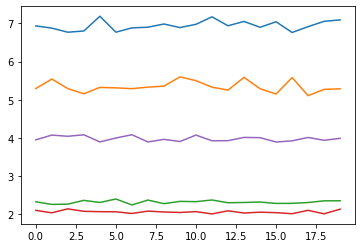

In [28]:
plt.plot(excess_returns.std(0))

In [29]:
batched_covs = torch.stack([torch.cov(x.t()) for x in excess_returns.permute(1, 0, 2)])
expected_returns = excess_returns.mean(0)

In [30]:
weights = torch.solve(expected_returns.unsqueeze(-1), batched_covs)[0]
# norm_weights = weights.squeeze(-1) / weights.abs().sum(-2)
# weights = weights.clamp(min=0.)
norm_weights = weights.squeeze(-1) / weights.abs().sum(-2)

/var/folders/ms/lbkrq70x7lnbnztclff1ln6r0000gn/T/ipykernel_916/647796589.py:1: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  weights = torch.solve(expected_returns.unsqueeze(-1), batched_covs)[0]


In [31]:
norm_weights.shape

torch.Size([20, 5])

In [32]:
from voltron.data import make_ticker_list, DataGetter, GetStockHistory

In [33]:
test_data = [GetStockHistory(tckr, end_date="2021-12-11") for tckr in tckrs]

In [34]:
test_y = torch.tensor([x.Close[-20:].values for x in test_data])

/var/folders/ms/lbkrq70x7lnbnztclff1ln6r0000gn/T/ipykernel_916/2083641220.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272478997/work/torch/csrc/utils/tensor_new.cpp:201.)
  test_y = torch.tensor([x.Close[-20:].values for x in test_data])


In [35]:
test_y.shape

torch.Size([5, 20])

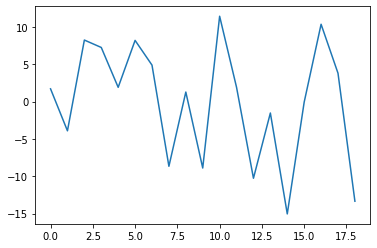

In [36]:
total_returns = (test_y - final_day_idx.unsqueeze(-1)) / 5
prior_value = torch.cat((final_day_idx.unsqueeze(-1), test_y[..., :-2]), dim=-1)
daily_return = test_y[..., :-1] - prior_value
plt.plot(daily_return.t().sum(1) / 5)

In [37]:
test_y.shape

torch.Size([5, 20])

In [38]:
prior_value.shape

torch.Size([5, 19])

In [39]:
eval_of_sharpe_strat = (norm_weights[:-1].t() * daily_return).sum(0).detach()

In [40]:
norm_weights[:-1].t().shape

torch.Size([5, 19])

Text(0.5, 1.0, 'Weights')

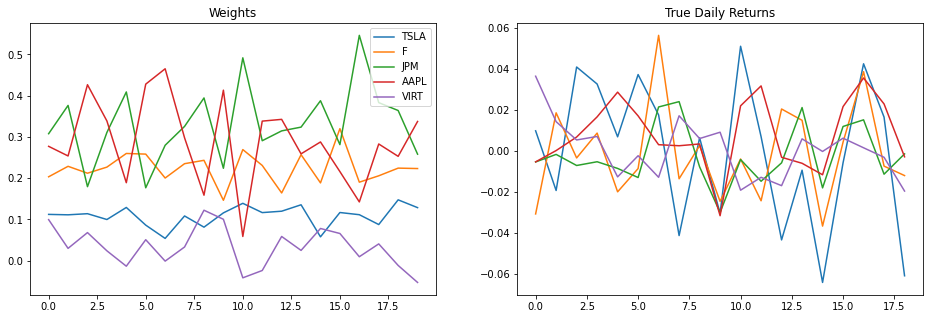

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))
# ax[0].plot(norm_weights, label = tckrs)
[ax[0].plot(norm_weights[:,i], label = tckrs[i]) for i in range(5)]
ax[1].plot((daily_return / prior_value).t())

ax[0].legend()
ax[1].set_title("True Daily Returns")
ax[0].set_title("Weights")

In [42]:
daily_return.shape

torch.Size([5, 19])

Text(0, 0.5, 'Value')

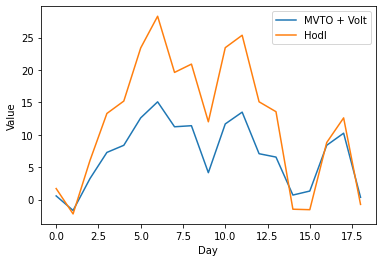

In [44]:
plt.plot(eval_of_sharpe_strat.cumsum(0), label = "MVTO + Volt")
plt.plot((daily_return.t().sum(1) / 5).cumsum(0), label = "Hodl")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Value")

In [45]:
x = torch.linspace(0, 2.5, 277 + 20)
train_x = x[:277]
test_x = x[277:]

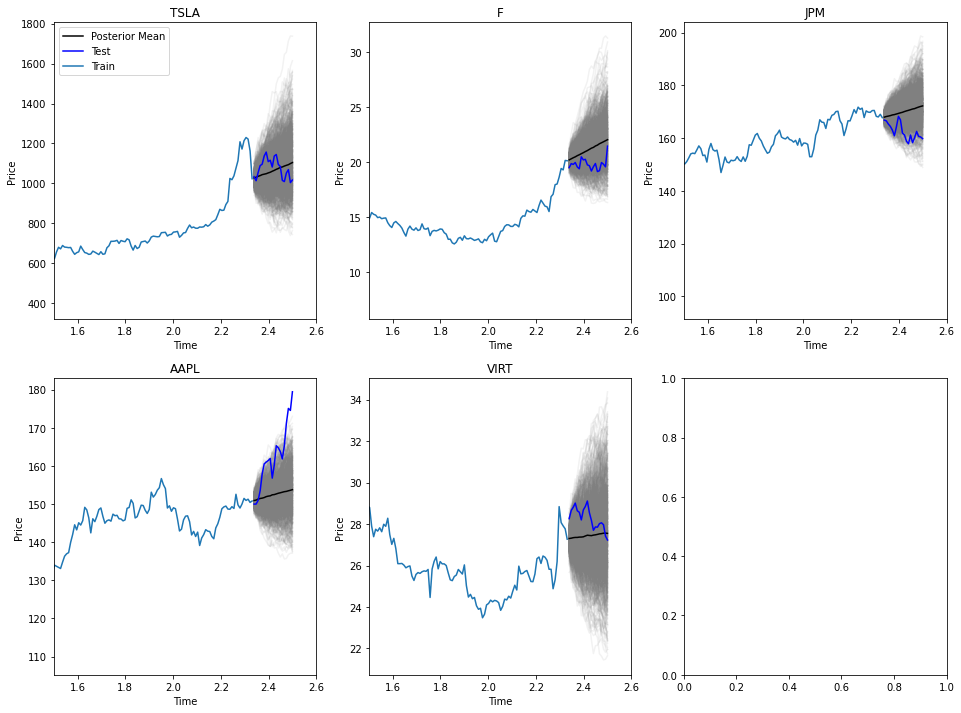

In [46]:
fig, ax = plt.subplots(2, 3, figsize = (16, 12))
ax = ax.reshape(-1)

for i in range(5):
    ax[i].plot(test_x, all_predictions[..., i].t(), color = "gray", alpha = 0.1)
    ax[i].plot(test_x, all_predictions.mean(0)[..., i], color = "black", label = "Posterior Mean")
    ax[i].plot(test_x, test_y[i, :20], color = "blue", label = "Test")
    ax[i].plot(train_x, all_predicions_and_data[i][0].Close, label = "Train")
    ax[i].set_xlim((1.5, 2.6))
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Price")
    ax[i].set_title(tckrs[i])
    
ax[0].legend()

In [171]:
test_y.shape

torch.Size([5, 20])

In [172]:
all_predictions.shape

torch.Size([1000, 20, 5])